In [1]:
import os
import json
import time
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(os.path.expanduser("./../plot_results"))

from datalakes import download_data_from_datalakes_dataset
from alplakes import download_3d_timeserie_from_api, parse_alplakes_json_3d_timeserie_to_df
from utils import save_json, try_download

## Download 3D Alplakes simulation

### Timeserie

In [2]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'
depth= 30
year_to_download = 2024

In [5]:
with open(os.path.join('../config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]

lat_station_wgs84 = config_points['lat_station_wgs84']
long_station_wgs84 = config_points['long_station_wgs84']

In [ ]:
for i in range (1,12):
    try:
        start_download_alplakes = f'{year_to_download}{str(i).zfill(2)}010000'
        end_download_alplakes = f'{year_to_download}{str(i+1).zfill(2)}010000'
        alplakes_json_timeserie_directory = rf"..\..\data\alplakes_3d\{sta_name}\timeseries_{depth}m"
        
        
        download_alplakes_from_api:bool = True
        save_timeserie_alplakes:bool = True
        # -------------------------------------
        start_clock = time.time()
        if download_alplakes_from_api:    
            alplakes_json = download_3d_timeserie_from_api(lake_name,
                                                      start_download_alplakes,
                                                      end_download_alplakes,
                                                      depth,
                                                      lat_station_wgs84,
                                                      long_station_wgs84
                                                      )
            alplakes_timeserie = parse_alplakes_json_3d_timeserie_to_df(alplakes_json)
            
            if save_timeserie_alplakes:
                alplakes_download_file_path = os.path.join(alplakes_json_timeserie_directory, f'{start_download_alplakes}.json')
                save_json(alplakes_json, alplakes_download_file_path)
        
        end_clock = time.time()
        print(f'Month {i} done. Operation took {end_clock - start_clock}s.')
    except:
        print(f"Ouups, didn't work for month {i}")
        continue

## Download Datalakes

### Known dataset type

Includes LéXPLORE Thermochain and Idronaut

In [1]:
import os
import shutil
import json
import time
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(os.path.expanduser("./../plot_results"))

from datalakes import download_data_from_datalakes_dataset
from alplakes import download_3d_timeserie_from_api, parse_alplakes_json_3d_timeserie_to_df
from utils import save_json, try_download

In [2]:
start_clock = time.time()

temp_folder = "./temp"
shutil.rmtree(temp_folder)
xr_measure = download_data_from_datalakes_dataset(600, datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc), datetime(2025, 1, 1, 0, 0, 0, tzinfo=timezone.utc), dataset_type="adcp_near_surface_velocity", datatype="json")

end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

Done. Operation took 21.98725390434265s.


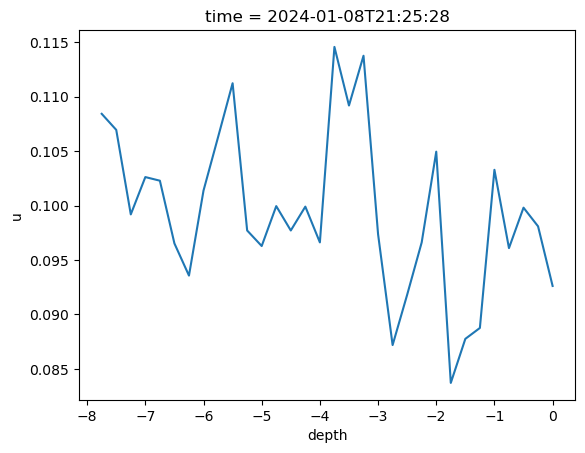

In [10]:
xr_measure['u'].isel(time = 500).plot()

In [8]:
xr_measure.to_netcdf(f'./datalakes/adcp_near_surface_velocity/2024.nc')

### Unknow Dataset type 

First have to figure out how to parse it

In [11]:
dataset_id = 600
response = try_download(f'https://api.datalakes-eawag.ch/files?datasets_id={dataset_id}')
files_properties = response.json()

In [12]:
response.json()

[{'id': 1396488,
  'datasets_id': 600,
  'filelink': 'files/600/1396488.json',
  'filetype': 'json',
  'filelineage': 1394843,
  'mindatetime': '2023-09-13T09:36:29.000Z',
  'maxdatetime': '2023-09-18T00:16:29.000Z',
  'mindepth': '-2.0600000000000005',
  'maxdepth': '7.69',
  'latitude': '-9999',
  'longitude': '-9999',
  'connect': 'join',
  'parameters_connectid': 1},
 {'id': 1550464,
  'datasets_id': 600,
  'filelink': 'git/128/acousticdopplercurrentprofiler/data/Level2/RDI600/L2_20240508_075533.nc',
  'filetype': 'nc',
  'filelineage': None,
  'mindatetime': None,
  'maxdatetime': None,
  'mindepth': None,
  'maxdepth': None,
  'latitude': None,
  'longitude': None,
  'connect': None,
  'parameters_connectid': None},
 {'id': 1423182,
  'datasets_id': 600,
  'filelink': 'git/128/acousticdopplercurrentprofiler/data/Level2/RDI600/L2_20231019_120256.nc',
  'filetype': 'nc',
  'filelineage': None,
  'mindatetime': None,
  'maxdatetime': None,
  'mindepth': None,
  'maxdepth': None,
  '

In [13]:
def get_ids_files_filtered_by_datatype(files_properties: json, datatype: str) -> list[int]:
    file_ids = []
    for file in files_properties:
        if file['filetype'] == datatype:
            file_ids.append(file['id'])

    if len(file_ids) == 0:
        raise FileNotFoundError(f"No data of type {datatype} found in {files_properties}")

    return file_ids

### json files

In [14]:
filtered_ids = get_ids_files_filtered_by_datatype(response.json(), 'json')

In [15]:
test_file_id = filtered_ids[-3]
response = try_download(f'https://api.datalakes-eawag.ch/download/{test_file_id}')

In [16]:
json_meas = response.json()

In [17]:
json_meas.keys()

dict_keys(['x', 'y', 'z', 'z1', 'z2', 'y1', 'y2', 'y3', 'y5', 'z3', 'z4', 'y6', 'z5', 'y4'])

In [18]:
np.array(json_meas['x']).shape

(85,)

In [19]:
np.array(json_meas['x'], dtype='datetime64[s]').astype('datetime64[ns]')

array(['2023-10-18T10:12:50.000000000', '2023-10-18T10:22:50.000000000',
       '2023-10-18T10:32:50.000000000', '2023-10-18T10:42:50.000000000',
       '2023-10-18T10:52:50.000000000', '2023-10-18T11:02:50.000000000',
       '2023-10-18T11:12:50.000000000', '2023-10-18T11:22:50.000000000',
       '2023-10-18T11:32:50.000000000', '2023-10-18T11:42:50.000000000',
       '2023-10-18T11:52:50.000000000', '2023-10-18T12:02:50.000000000',
       '2023-10-18T12:12:50.000000000', '2023-10-18T12:22:50.000000000',
       '2023-10-18T12:32:50.000000000', '2023-10-18T12:42:50.000000000',
       '2023-10-18T12:52:50.000000000', '2023-10-18T13:02:50.000000000',
       '2023-10-18T13:12:50.000000000', '2023-10-18T13:22:50.000000000',
       '2023-10-18T13:32:50.000000000', '2023-10-18T13:42:50.000000000',
       '2023-10-18T13:52:50.000000000', '2023-10-18T14:02:50.000000000',
       '2023-10-18T14:12:50.000000000', '2023-10-18T14:22:50.000000000',
       '2023-10-18T14:32:50.000000000', '2023-10-18

In [20]:
np.array(json_meas['y'])

array([ 7.69,  7.44,  7.19,  6.94,  6.69,  6.44,  6.19,  5.94,  5.69,
        5.44,  5.19,  4.94,  4.69,  4.44,  4.19,  3.94,  3.69,  3.44,
        3.19,  2.94,  2.69,  2.44,  2.19,  1.94,  1.69,  1.44,  1.19,
        0.94,  0.69,  0.44,  0.19, -0.06, -0.31, -0.56, -0.81, -1.06,
       -1.31, -1.56, -1.81, -2.06])

### netcdf files

In [3]:
import io
import xarray as xr

with open("./temp/data_1375276.nc", "wb") as file:
    file.write(response.content)

xr_ds = xr.open_dataset("./temp/data_1375276.nc", engine="netcdf4")

In [4]:
xr_ds = xr.open_dataset("./temp/data_1375276.nc", engine="netcdf4")

In [22]:
xr_ds

<xarray.Dataset> Size: 6MB
Dimensions:    (time: 706, depth: 110)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2020-07-24T14:41:40 ... 2020-07-29T1...
  * depth      (depth) float64 880B 11.11 12.11 13.11 ... 118.1 119.1 120.1
Data variables: (12/17)
    u          (depth, time) float64 621kB ...
    v          (depth, time) float64 621kB ...
    temp       (time) float64 6kB ...
    echo1      (depth, time) float64 621kB ...
    echo2      (depth, time) float64 621kB ...
    echo3      (depth, time) float64 621kB ...
    ...         ...
    time_qual  (time) float64 6kB ...
    u_qual     (depth, time) float64 621kB ...
    v_qual     (depth, time) float64 621kB ...
    mU         (time) float64 6kB ...
    mdir       (time) float64 6kB ...
    Sv         (depth, time) float64 621kB ...
Attributes: (12/16)
    institution:       EPFL
    source:            ADCP
    references:        LéXPLORE commun instruments camille.minaudo@epfl.ch>
    history:           See history on Renku
    conventions:       CF 1.7
    comment:           Data from ADCP on Lexplore Platform in Lake Geneva
    ...                ...
    up:                False
    bottom_depth:      110
    transducer_depth:  8
    beam_angle:        20.0
    xmit_length:       0.96
    beam_freq:         300.0

In [ ]:
plt.plot(json_data['x'])